# Variability analysis for HBEC IFN experiment

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [4]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts.h5ad')

In [5]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [6]:
adata.shape

(69252, 36588)

### Read 1d HT result comparing to control

In [12]:
cts = [['ciliated'], ['bc', 'club'], ['basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [13]:
def read_result(ct):
    
    adata_dict = {}
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        adata_dict[stim] = {}
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_dict[stim][tp] = sc.read('/data_volume/ifn_hbec/binary_test/{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_dict[stim][tp])
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_dict[stim][tp], groupby='time_step')
    return adata_dict,ht_dict,moments_dict

In [14]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['adata'], all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

### Number of DE and DV genes over time

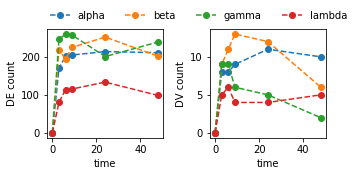

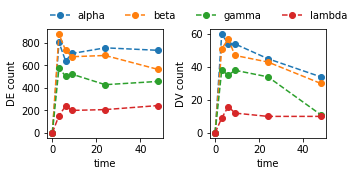

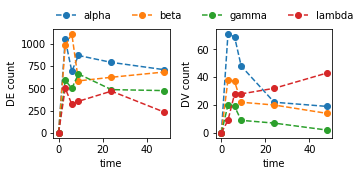

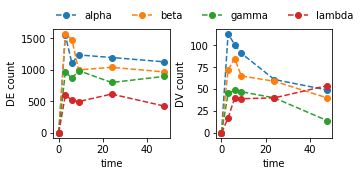

In [96]:
def plot_num_de_dv(ct):
    de_count, dv_count = np.zeros((len(stims), len(tps))), np.zeros((len(stims), len(tps)))
    for i, stim in enumerate(stims):
        for j, tp in enumerate(tps):
            
            if ct == 'all':
                combined_df = pd.concat([all_result['-'.join(c)]['ht'][stim][tp] for c in cts])
                de_count[i, j] = combined_df.query('de_fdr < 0.05 & de_coef >0').gene.drop_duplicates().shape[0]
                dv_count[i, j] = combined_df.query('dv_fdr < 0.1 & de_coef>0').gene.drop_duplicates().shape[0]
            else:
                de_count[i, j] = all_result[ct]['ht'][stim][tp].query('de_fdr < 0.05 & de_coef>0').shape[0]
                dv_count[i, j] = all_result[ct]['ht'][stim][tp].query('dv_fdr < 0.1 & de_coef>0').shape[0]
    de_count = np.hstack([np.zeros((len(stims), 1)), de_count])
    dv_count = np.hstack([np.zeros((len(stims), 1)), dv_count])
    plt.figure(figsize=(5, 2));
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(1, 2, 1);
    for i in range(len(stims)):
        plt.plot([0.0]+[float(int(tp)) for tp in tps], de_count[i, :], '--o')
    plt.ylabel('DE count'); plt.legend(stims, loc='upper center', ncol=4, bbox_to_anchor=(1.3, 1.25), frameon=False); plt.xlabel('time')
    plt.subplot(1, 2, 2);
    for i in range(len(stims)):
        plt.plot([0.0]+[float(int(tp)) for tp in tps], dv_count[i, :], '--o')
    plt.ylabel('DV count'); plt.xlabel('time')
    
plot_num_de_dv('basal')
plot_num_de_dv('bc-club')
plot_num_de_dv('ciliated')
plot_num_de_dv('all')

### Get HT result and moments

In [51]:
moment_df_list = []
ht_df_list = []

In [52]:
for ct in cts:
    
    key = key = '-'.join(ct)
    for stim in stims:
        for tp in tps:
            
            df = all_result[key]['ht'][stim][tp]
            df['stim'] = stim
            df['ct'] = key
            df['tp'] = int(tp)
            
            ht_df_list.append(df.copy())
ht_df = pd.concat(ht_df_list)

In [53]:
for ct in cts:
    
    key = key = '-'.join(ct)
    for stim in stims:
        for tp in tps:
            
            df_ctrl = pd.DataFrame()
            df_ctrl['gene'] = all_result[key]['moments'][stim][tp][0]['gene'].tolist()
            df_ctrl['mean'] = all_result[key]['moments'][stim][tp][0]['0'].tolist()
            df_ctrl['var'] = all_result[key]['moments'][stim][tp][1]['0'].tolist()
            df_ctrl['stim'] = 'ctrl'
            df_ctrl['ct'] = key
            df_ctrl['tp'] = 0
            
            df_stim = pd.DataFrame()
            df_stim['gene'] = all_result[key]['moments'][stim][tp][0]['gene'].tolist()
            df_stim['mean'] = all_result[key]['moments'][stim][tp][0]['1'].tolist()
            df_stim['var'] = all_result[key]['moments'][stim][tp][1]['1'].tolist()
            df_stim['stim'] = stim
            df_stim['ct'] = key
            df_stim['tp'] = int(tp)
            
            moment_df_list.append(df_ctrl)
            moment_df_list.append(df_stim)
moment_df = pd.concat(moment_df_list).drop_duplicates()

### Plot effect sizes

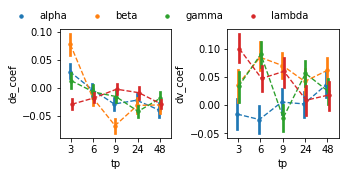

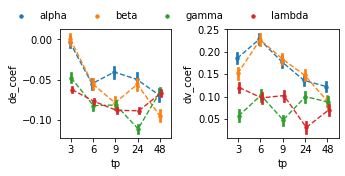

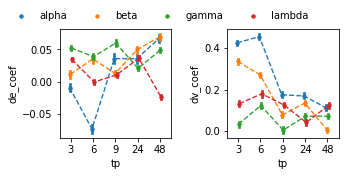

In [84]:
def plot_es(ct):
    plt.figure(figsize=(5, 2));
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, 2, 1)
    sns.pointplot(x='tp', y='de_coef', hue='stim', data=ht_df.query('ct == "{}"'.format(ct)), ci=66, dodge=True, linestyles='--', scale=.5); plt.legend(loc='upper center', bbox_to_anchor=(0.9, 1.25), ncol=4, frameon=False)
    plt.subplot(1, 2, 2)
    sns.pointplot(x='tp', y='dv_coef', hue='stim', data=ht_df.query('ct == "{}"'.format(ct)), ci=66, dodge=True, linestyles='--', scale=.5); plt.legend([], frameon=False)
plot_es('basal')
plot_es('bc-club')
plot_es('ciliated')

### Plot moments

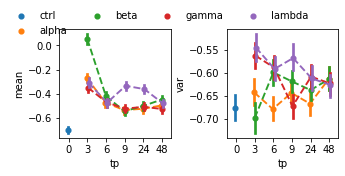

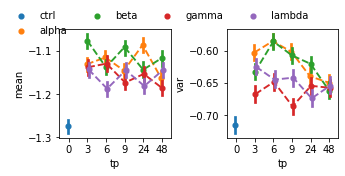

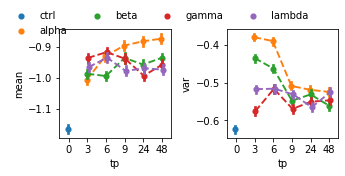

In [85]:
def plot_moments(ct):
    plt.figure(figsize=(5, 2));
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, 2, 1)
    sns.pointplot(x='tp', y='mean', hue='stim', data=moment_df.query('ct == "{}"'.format(ct)), ci=66, dodge=True, linestyles='--', scale=.7); plt.legend(loc='upper center', bbox_to_anchor=(0.9, 1.25), ncol=4, frameon=False)
    plt.subplot(1, 2, 2)
    sns.pointplot(x='tp', y='var', hue='stim', data=moment_df.query('ct == "{}"'.format(ct)), ci=66, dodge=True, linestyles='--', scale=.7); plt.legend([], frameon=False)
plot_moments('basal')
plot_moments('bc-club')
plot_moments('ciliated')